#### NOTEBOOK OVERVIEW: This notebook was created as a start to finish Databricks-based machine learning pipeline to predict if an employee will leave a company given some general HR data. The data set used has ~15K records and includes data points like satisfaction_level (%), number of projects during tenure, average monthly hours, time with company (in years), employee promotion in the last 5 years (yes or no), salary scale (low, medium, or high). The dataset can be found here: https://data.world/nissijohn/hr-attrition-analysis-and-prediction/workspace/file?filename=HR_data.csv. Names were randomly generated (via faker python library) in a separate notebook and appended to the downloaded dataset.

#### NOTEBOOK FUNCTIONALITY: This notebook ingests the dataset manually uploaded to DBFS, performs basic EDA, feature engineers randomly generated start and end dates where applicable, pre-processes data, and trains a model to make predictions.

### Ingest Data from DBFS

In [0]:
# specify file path and read .csv
file_location = '/FileStore/tables/HR_data-2.csv'
df = spark.read.csv(file_location, header="True", inferSchema="True")
df = df.withColumnRenamed('salary scale', 'salary_scale')

display(df.limit(10))

# look at data types of df to verify that schema was inferred properly
print(df.dtypes)

# create temporary table of .csv to run some initial sql queries to better understand the data
temp_table_name = "HR_data_csv"
df.createOrReplaceTempView(temp_table_name)

id,name,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary_scale
3.00092E13,Harry Gomez,0.38,0.53,2,157,3,0,1,0,sales,low
4.02694E15,Kyle Rodriquez,0.8,0.86,5,262,6,0,1,0,sales,medium
5.61039E15,Mae Tucker,0.11,0.88,7,272,4,0,1,0,sales,medium
5.48236E15,Alan Pope,0.72,0.87,5,223,5,0,1,0,sales,low
3.68504E13,Essie Harvey,0.37,0.52,2,159,3,0,1,0,sales,low
6.01126E15,Rosa Bryan,0.41,0.5,2,153,3,0,1,0,sales,low
3.42219E14,Marie Walker,0.1,0.77,6,247,4,0,1,0,sales,low
6.33422E15,Maria Walton,0.92,0.85,5,259,5,0,1,0,sales,low
3.67618E13,Frederick Hopkins,0.89,1.0,5,224,5,0,1,0,sales,low
3.66085E13,Matthew Gomez,0.42,0.53,2,142,3,0,1,0,sales,low


[('id', 'double'), ('name', 'string'), ('satisfaction_level', 'double'), ('last_evaluation', 'double'), ('number_project', 'int'), ('average_montly_hours', 'int'), ('time_spend_company', 'int'), ('Work_accident', 'int'), ('left', 'int'), ('promotion_last_5years', 'int'), ('department', 'string'), ('salary_scale', 'string')]


### Feature Engineering
#### - Add start and end dates

In [0]:
%sql
-- find the maximum time an employee has spent with the company, relevant for generating random start and end dates below
SELECT max(time_spend_company) FROM HR_data_csv

max(time_spend_company)
10


In [0]:
# Assume that the fictitious company was founded in 2011 and employee hiring is staggered - based on the maximum tenure being 10 years and this notebook being developed in 2021
# create user-defined functions to generate a random start and end date based on time spent w/ company and employment status 
import random
from pyspark.sql.types import IntegerType

def get_start_date(left, time_spent):
  if left == 1:
    start_date = random.randint(2011, 2021-time_spent)
  else:
    start_date = 2021-time_spent
  return start_date

def get_end_date(left, start, time_spent):
  if left == 1:
    end_date = start + time_spent
  else:
    end_date = None
  return end_date

start_udf = udf(get_start_date, IntegerType())
end_udf = udf(get_end_date, IntegerType())

In [0]:
# add start_date and end_date columns, update temp table
df = df.withColumn("start_date", start_udf("left", "time_spend_company")).withColumn("end_date", end_udf("left", "start_date", "time_spend_company"))
display(df.limit(10))
df.createOrReplaceTempView(temp_table_name)

id,name,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary_scale,start_date,end_date
3.00092E13,Harry Gomez,0.38,0.53,2,157,3,0,1,0,sales,low,2011,2014
4.02694E15,Kyle Rodriquez,0.8,0.86,5,262,6,0,1,0,sales,medium,2015,2021
5.61039E15,Mae Tucker,0.11,0.88,7,272,4,0,1,0,sales,medium,2014,2018
5.48236E15,Alan Pope,0.72,0.87,5,223,5,0,1,0,sales,low,2016,2021
3.68504E13,Essie Harvey,0.37,0.52,2,159,3,0,1,0,sales,low,2014,2017
6.01126E15,Rosa Bryan,0.41,0.5,2,153,3,0,1,0,sales,low,2018,2021
3.42219E14,Marie Walker,0.1,0.77,6,247,4,0,1,0,sales,low,2012,2016
6.33422E15,Maria Walton,0.92,0.85,5,259,5,0,1,0,sales,low,2015,2020
3.67618E13,Frederick Hopkins,0.89,1.0,5,224,5,0,1,0,sales,low,2015,2020
3.66085E13,Matthew Gomez,0.42,0.53,2,142,3,0,1,0,sales,low,2016,2019


In [0]:
%sql
-- verify min and max start and end dates to verify that the UDFs worked properly
SELECT max(start_date), min(start_date), max(end_date), min(end_date)
FROM HR_data_csv

max(start_date),min(start_date),max(end_date),min(end_date)
2019,2011,2021,2013


In [0]:
%sql
-- verify that the UDFs worked properly, the query should not return any results
SELECT * FROM HR_data_csv
WHERE start_date + time_spend_company != end_date

id,name,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary_scale,start_date,end_date


In [0]:
%sql
-- verify that the UDFs worked properly, the query should not return any results
SELECT * FROM HR_data_csv
WHERE end_date is not null AND HR_data_csv.left = 0

id,name,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary_scale,start_date,end_date


### ML Pre-processing
#### * add standard scaling

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# split train/test sets (70/30) before any pre-processing
train_df, test_df = df.randomSplit([.70, .30], seed=42)
train_df = train_df.drop("id", "name", "start_date", "end_date")
test_df = test_df.drop("id", "name", "start_date", "end_date")

# separate features and labels 
cat_cols = ["department", "salary_scale"]

# one hot encode categorical columns (using string indexing, one-hot encoding)
stringIndexer = StringIndexer(inputCols=cat_cols, outputCols=[x + "_index" for x in cat_cols])
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "_OHE" for x in cat_cols])

# create a single vector
num_cols = ["satisfaction_level", "last_evaluation", "number_project", "average_montly_hours", "time_spend_company", "Work_accident", "promotion_last_5years"]

assemblerInputs = [x + "_OHE" for x in cat_cols] + num_cols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# standardize and scale features
scaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")

### Basic EDA

In [0]:
# view company size and attrition by year
from pyspark.sql.functions import *

cols = ["year", "left", "joined", "stayed"]
year_df = []

for i in range(2011,2022):
  year = i
  left = df.where(col("end_date")==i).count()
  joined = df.where(col("start_date")==i).count()
  stayed = df.where(
    (col("start_date") < i) & ((col("end_date") > i) | (col("end_date").isNull()))).count()
  year_df.append([year, left, joined, stayed])
  
year_df = spark.createDataFrame(year_df, schema=cols).withColumn("size", col("joined")+col("stayed")-col("left"))

In [0]:
display(year_df)
year_df.createOrReplaceTempView("years")

year,left,joined,stayed,size
2011,0,693,0,693
2012,0,541,749,1290
2013,4,642,1221,1859
2014,180,677,1731,2228
2015,328,1019,2075,2766
2016,446,1069,2624,3247
2017,507,2013,3157,4663
2018,495,5072,4760,9337
2019,491,3197,9241,11947
2020,484,0,11942,11458


In [0]:
%sql
-- plot company size and attrition by year (used Databricks UI to plot - will appear as table outside of Databricks)
SELECT year, size, joined, left FROM years

year,size,joined,left
2011,693,693,0
2012,1290,541,0
2013,1859,642,4
2014,2228,677,180
2015,2766,1019,328
2016,3247,1069,446
2017,4663,2013,507
2018,9337,5072,495
2019,11947,3197,491
2020,11458,0,484


In [0]:
%sql
-- plot attrition rate by year (used Databricks UI to plot - will appear as table outside of Databricks)
SELECT year, years.left/years.size * 100 as percent_attrition FROM years

year,percent_attrition
2011,0.0
2012,0.0
2013,0.21516944593867668
2014,8.07899461400359
2015,11.85827910339841
2016,13.735756082537728
2017,10.872828651082994
2018,5.301488700867516
2019,4.1098183644429565
2020,4.224122883574795


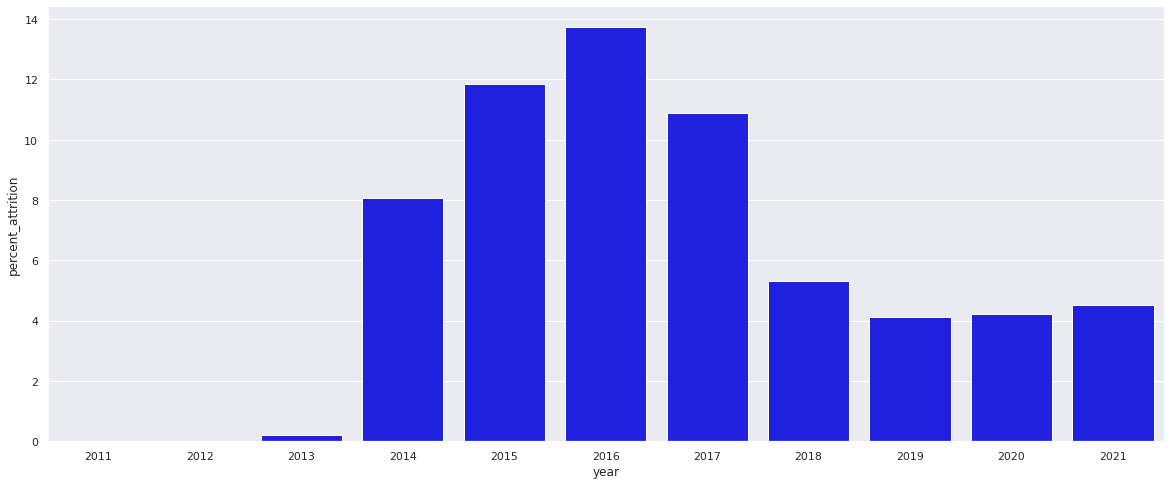

In [0]:
# plot the above attrition rate by year 
import seaborn as sns
attrition_query_df = spark.sql('SELECT year, years.left/years.size * 100 as percent_attrition FROM years').toPandas()

# plot attrition rate by year
sns.set_context("notebook")
sns.set_theme()
sns.set_color_codes()
sns.set(rc = {'figure.figsize':(20,8)})
attrition_plot = sns.barplot(data = attrition_query_df, x = 'year', y = 'percent_attrition', color='blue')

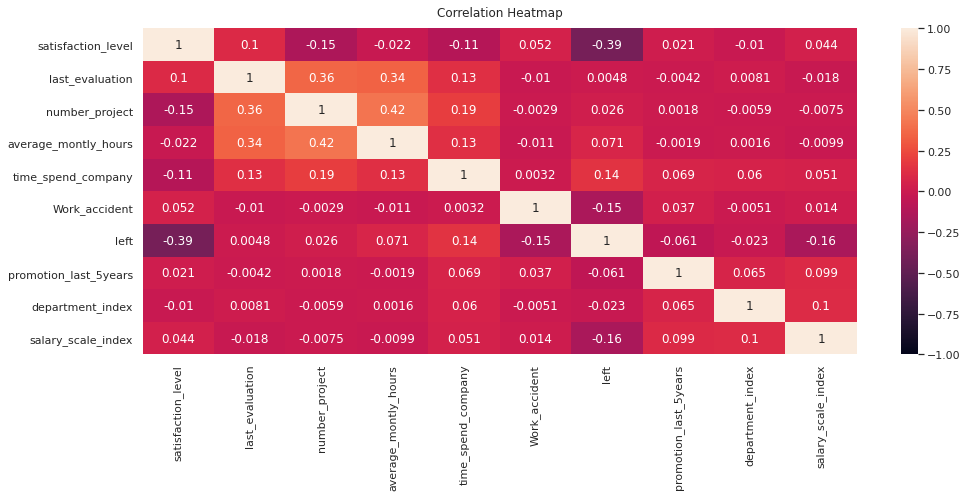

In [0]:
# correlation heatmap of labels and features
import pandas as pd
import matplotlib.pyplot as plt

pandasDF = stringIndexer.fit(train_df).transform(train_df).drop("id","name", "department", "salary_scale")

pandasDF = pandasDF.toPandas()
                                                              
corr=pandasDF.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### ML Pipeline - Random Forest Regressor

In [0]:
# set up classification (random forest) model w/ PySpark ML library
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# random forest model 
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="left")

# define pipeline stages
pipeline = Pipeline(stages=[stringIndexer, encoder, vecAssembler, scaler, rf])

# define scoring evaluators
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")

pipelineModel = pipeline.fit(train_df)
pred_df = pipelineModel.transform(train_df)
display(pred_df.limit(10))

# set up ML Flow run with auto log-enable
# mlflow.ml.autolog()
# with mlflow.start_run(): 

paramGrid = (ParamGridBuilder()
           .addGrid(rf.maxDepth, [2, 5, 10])
           .addGrid(rf.maxBins, [10, 20, 40])
           .addGrid(rf.numTrees, [5, 20, 50])
           .build())

# create a 5-fold CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=bcEvaluator.setLabelCol("left"), numFolds=5, parallelism=4)

# run cross-validations
cvModel = cv.fit(train_df)

# use model identified by cv to make predictions on test set
cv_pred_df = cvModel.transform(test_df)

# evaluate performance
print(f"Area under ROC Curve: {bcEvaluator.evaluate(cv_pred_df)}")

satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary_scale,department_index,salary_scale_index,department_OHE,salary_scale_OHE,features,scaled_features,rawPrediction,probability,prediction
0.62,0.54,4,212,4,0,0,0,support,medium,2.0,1.0,"Map(vectorType -> sparse, length -> 9, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(2, 10, 11, 12, 13, 14, 15), values -> List(1.0, 1.0, 0.62, 0.54, 4.0, 212.0, 4.0))","Map(vectorType -> sparse, length -> 18, indices -> List(2, 10, 11, 12, 13, 14, 15), values -> List(2.805807680862972, 2.0199000634813116, 2.486165154472333, 3.1511197427934814, 3.2420142431216994, 4.23540992281057, 2.7317058613361866))","Map(vectorType -> dense, length -> 2, values -> List(18.825385141302224, 1.1746148586977763))","Map(vectorType -> dense, length -> 2, values -> List(0.9412692570651112, 0.058730742934888815))",0.0
0.94,0.94,3,255,3,0,0,0,IT,low,3.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(3, 9, 11, 12, 13, 14, 15), values -> List(1.0, 1.0, 0.94, 0.94, 3.0, 255.0, 3.0))","Map(vectorType -> sparse, length -> 18, indices -> List(3, 9, 11, 12, 13, 14, 15), values -> List(3.6494114585927053, 2.0005338956584784, 3.7693471696838596, 5.485282515233097, 2.4315106823412744, 5.094478916588185, 2.04877939600214))","Map(vectorType -> dense, length -> 2, values -> List(17.932358488778924, 2.067641511221076))","Map(vectorType -> dense, length -> 2, values -> List(0.8966179244389462, 0.1033820755610538))",0.0
0.72,0.94,4,235,3,0,0,0,technical,medium,1.0,1.0,"Map(vectorType -> sparse, length -> 9, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(1, 10, 11, 12, 13, 14, 15), values -> List(1.0, 1.0, 0.72, 0.94, 4.0, 235.0, 3.0))","Map(vectorType -> sparse, length -> 18, indices -> List(1, 10, 11, 12, 13, 14, 15), values -> List(2.5932204012337188, 2.0199000634813116, 2.887159534225935, 5.485282515233097, 3.2420142431216994, 4.694911942738131, 2.04877939600214))","Map(vectorType -> dense, length -> 2, values -> List(18.29159169160533, 1.7084083083946724))","Map(vectorType -> dense, length -> 2, values -> List(0.9145795845802663, 0.08542041541973361))",0.0
0.36,0.56,2,132,3,0,1,0,IT,medium,3.0,1.0,"Map(vectorType -> sparse, length -> 9, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(3, 10, 11, 12, 13, 14, 15), values -> List(1.0, 1.0, 0.36, 0.56, 2.0, 132.0, 3.0))","Map(vectorType -> sparse, length -> 18, indices -> List(3, 10, 11, 12, 13, 14, 15), values -> List(3.6494114585927053, 2.0199000634813116, 1.4435797671129675, 3.2678278814154624, 1.6210071215608497, 2.6371420274103547, 2.04877939600214))","Map(vectorType -> dense, length -> 2, values -> List(3.5892486333220788, 16.41075136667792))","Map(vectorType -> dense, length -> 2, values -> List(0.17946243166610393, 0.820537568333896))",1.0
0.85,0.63,3,167,3,0,0,0,product_mng,medium,4.0,1.0,"Map(vectorType -> sparse, length -> 9, indices -> List(4), values -> List(1.0))","Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(4, 10, 11, 12, 13, 14, 15), values -> List(1.0, 1.0, 0.85, 0.63, 3.0, 167.0, 3.0))","Map(vectorType -> sparse, length -> 18, indices -> List(4, 10, 11, 12, 13, 14, 15), values -> List(4.210437516048071, 2.0199000634813116, 3.408452227905618, 3.676306366592395, 2.4315106823412744, 3.3363842316479486, 2.04877939

Deprecation warning: The PySpark MLlib + MLflow Tracking integration is deprecated. Soon, we will remove this feature and replace it with MLflow PySpark ML autologging and Databricks Autologging.
 To try the new MLflow PySpark ML autologging feature, which will be enabled by default in an upcoming release, call `mlflow.pyspark.ml.autolog()`.
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Area under ROC Curve: 0.9874896344963894


### Model Feature Importance

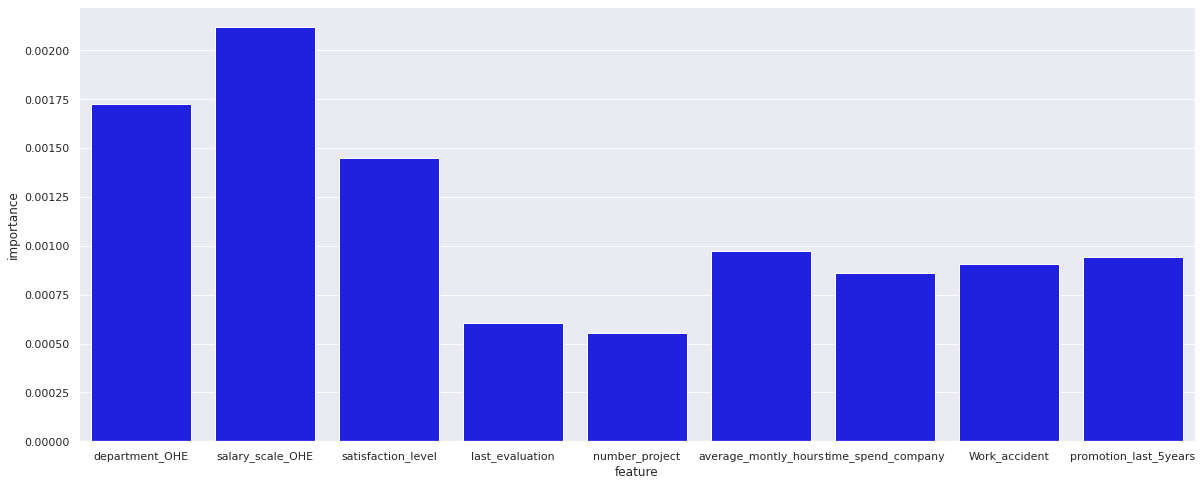

In [0]:
# extract feature importance from model and plot
from pyspark.sql.types import *

# isolate best performing model
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[-1]
  
# define variables for feature importance
va = bestPipeline.stages[-3] # extract vecAssembler from pipeline
importances = list(zip(va.getInputCols(), bestModel.featureImportances))

implist = []
for importance in importances:
  imp = list(importance)
  alist = [imp[0], float(imp[1])]
  implist.append(alist)
  
# specify schema of array to be converted to spark df
schema = StructType([
    StructField("feature", StringType(), True),
    StructField("importance", FloatType(), True)
  ]
)

impDF = spark.createDataFrame(implist, schema=schema)
# display(impDF.sort(col("importance").desc()))

# convert to pandas df for plotting
imp_pandas_df = impDF.toPandas()

# plot feature importance
sns.set_context("notebook")
sns.set_theme()
sns.set_color_codes()
sns.set(rc = {'figure.figsize':(20,8)})
feature_importance_plot = sns.barplot(data = imp_pandas_df, x = 'feature', y = 'importance', color='blue')

### Model Predictions

In [0]:
# use best cv model to make predictions on raw data set
from pyspark.ml.functions import vector_to_array

# look at predictions of employees leaving (where predicted probablity >= 50%)
final_pred = bestPipeline.transform(df).select("id", "name", "probability")
final_pred = (final_pred.withColumn("prob (%)",vector_to_array(col("probability"))[1])
              .withColumn("prob (%)", (col("prob (%)").cast("decimal (10,4)") * 100).cast("decimal (10,2)"))
              .drop("probability")
              .sort(col("prob (%)")
                    .desc())
              .filter(col("prob (%)") >= .5)
             )

display(final_pred.limit(10))

id,name,prob (%)
3.67661E13,Catherine Johnston,100.00
3.65477E13,Gussie Bryan,100.00
6.37964E15,Georgia Nichols,100.00
6.01106E15,Caroline Bates,99.97
2.01492E14,Sue Blair,99.97
6.01126E15,Wayne Santos,99.97
3.6536E13,Brent Holmes,99.92
3.52875E15,Caleb Stephens,99.92
4.02644E15,Margaret Norris,99.91
6.29801E15,Ronnie Stone,99.91


### Top Flight Risk for Current Employees

In [0]:
# Display the top 10 most at risk employees who are still with the company
risk = final_pred.join(df, ["id", "name"]).where(col("left")==0).sort((col("prob (%)").desc()))
display(risk.limit(10))

id,name,prob (%),satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary_scale,start_date,end_date
3.48744E14,Nellie Miller,99.03,0.39,0.57,2,132,3,0,0,0,support,low,2018,null
5.48534E15,David Hardy,98.24,0.43,0.51,2,123,3,0,0,0,technical,medium,2018,null
4.08709E15,Marie Ortiz,97.53,0.42,0.5,2,151,3,0,0,0,sales,low,2018,null
6.30435E15,Gene Daniel,97.38,0.44,0.45,2,124,3,0,0,0,sales,low,2018,null
6.33402E15,Adelaide Hughes,96.86,0.37,0.51,2,153,3,0,0,0,IT,high,2018,null
3.63654E13,Minerva Mendez,96.86,0.37,0.51,2,153,3,0,0,0,IT,high,2018,null
4.02663E15,Mittie Drake,92.60,0.38,0.51,2,120,3,0,0,0,RandD,low,2018,null
3.00369E13,Alejandro Black,92.27,0.73,0.83,5,266,5,0,0,0,sales,low,2016,null
5.41482E15,Grace Holland,92.04,0.9,0.87,4,231,5,0,0,0,management,low,2016,null
5.61091E15,Chester Holland,91.23,0.86,0.96,5,238,5,0,0,0,technical,low,2016,null
